# SHAP Aggregation Insights

* Show signed feature importance, comparing with SHAP summary plot
* Aggregated all forece plots results together, show signed feature contribution to the forecasting values
* SHAP version is `shap==0.41.0`

In [1]:
import pandas as pd
import timeit
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Get a Trained Model

In [2]:
df = pd.read_pickle('sales.pkl')

y = df['Sales']
X = df.drop(['Sales', 'Date'], axis=1)

print(X.shape, y.shape)
X.head()

(693861, 19) (693861,)


,Store,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,-1,5,555,1,1,0,1
1,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,-1,4,546,1,1,0,1
2,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,-1,3,523,1,1,0,1
3,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,-1,2,560,1,1,0,1
4,1,2015,7,3,2,0,1270.0,9,2008,0,-1,-1,-1,1,612,1,1,0,1


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

params = {
    'num_leaves': 10786,
    'learning_rate': 0.23324362552743075,
    'subsample': 0.5960525260632918,
    'max_bin': 9,
    'colsample_bytree': 0.9792283949360767,
    'reg_alpha': 0.11863728553565003,
    'reg_lambda': 6.4741850755867505,
    'max_depth': 7,
}

model = LGBMRegressor(objective='regression', metric='mape',
                       random_state=10, **params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'Testing R2 is {r2}')

(485702, 19) (485702,) (208159, 19) (208159,)
Testing R2 is 0.9743443676632644


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

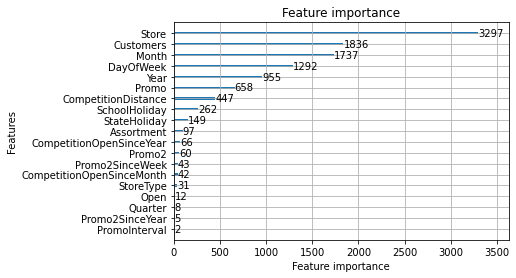

In [4]:
lgb.plot_importance(model)

## SHAP Built-in Insights

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
base_value = explainer.expected_value
if isinstance(base_value, list):
    base_value = base_value[1]
print(f"Explainer expected value (Base Value): {base_value}")

Explainer expected value (Base Value): 5780.181628365994


In [16]:
shap_df = pd.DataFrame(shap_values)
shap_df.columns = X_test.columns
shap_df['SHAP_SUM'] = shap_df.sum(axis=1) + base_value
shap_df['FORECAST'] = y_pred

print(min(y_test), min(shap_df['FORECAST']), min(shap_df['SHAP_SUM']))  # there are negative forecasted values
print(f"{round(shap_df[shap_df['FORECAST'] < 0].shape[0]*100/shap_df.shape[0], 2)}%")  # % of negative predicted values

shap_df.head()

0 -999.4370074061887 -999.4370074061544
8.7%


,Store,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,Promo2SinceYear,PromoInterval,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,SHAP_SUM,FORECAST
0,-301.804423,-40.133411,27.526826,-0.116303,-321.732469,-0.357623,-37.905468,2.608518,-5.379309,-0.292043,...,-0.013057,-0.005997,-140.538391,465.032259,-0.326455,439.708337,4.148274,44.019191,5879.488056,5879.488056
1,52.261353,14.548377,-61.248213,0.035854,-247.878871,0.446048,25.379526,0.016869,-0.593962,-1.947640,...,-0.035195,-0.021433,49.131173,-1952.150073,-0.394149,-308.237355,14.316312,-18.706777,3322.294628,3322.294628
2,-1571.502920,10.187321,712.175132,0.115767,-366.405126,-2.187785,-68.073678,11.976317,30.417701,-0.536249,...,0.098775,-0.012664,310.327783,1648.775076,-0.333053,599.935753,3.328111,-17.810667,6988.385388,6988.385388
3,-471.061350,-73.263230,38.317659,0.166240,-167.630221,-0.342744,-109.470681,-1.257832,-37.257115,2.173073,...,0.208052,0.122016,143.205403,3174.854570,-0.283164,-645.524508,5.978089,-24.577913,7631.097373,7631.097373
4,373.185951,23.774077,-89.579428,0.537503,473.001651,0.674567,-9.143534,-0.053554,0.724014,-2.961231,...,-0.034798,0.014945,34.833021,-952.093810,-0.316126,-468.935099,3.882291,-15.684386,5138.216916,5138.216916


In [20]:
exp = shap.Explanation(shap_values, 
                  base_value, 
                  data=X_test.values, 
                  feature_names=X_test.columns)
print(exp.shape)
exp

(208159, 19)


.values =
array([[-3.01804423e+02, -4.01334111e+01,  2.75268261e+01, ...,
         4.39708337e+02,  4.14827400e+00,  4.40191907e+01],
       [ 5.22613534e+01,  1.45483773e+01, -6.12482130e+01, ...,
        -3.08237355e+02,  1.43163121e+01, -1.87067769e+01],
       [-1.57150292e+03,  1.01873214e+01,  7.12175132e+02, ...,
         5.99935753e+02,  3.32811106e+00, -1.78106670e+01],
       ...,
       [-1.01447933e+02, -1.06622564e+00, -1.18504139e+01, ...,
        -2.20851703e+02,  1.69310572e+00, -1.45085557e+01],
       [-2.10769183e+02,  5.92874106e+01,  1.68254327e+01, ...,
        -2.96986196e+02,  2.00942777e+00, -1.43068285e+01],
       [ 2.50655339e+02,  3.31358041e+01, -8.84048138e+01, ...,
        -3.60906899e+02,  7.82108365e+00, -3.83835357e+00]])

.base_values =
5780.181628365994

.data =
array([['6', 2014, 7, ..., 1, '0', 1],
       ['315', 2014, 4, ..., 0, '0', 0],
       ['569', 2014, 12, ..., 1, '0', 0],
       ...,
       ['223', 2014, 3, ..., 0, '0', 0],
       ['905', 

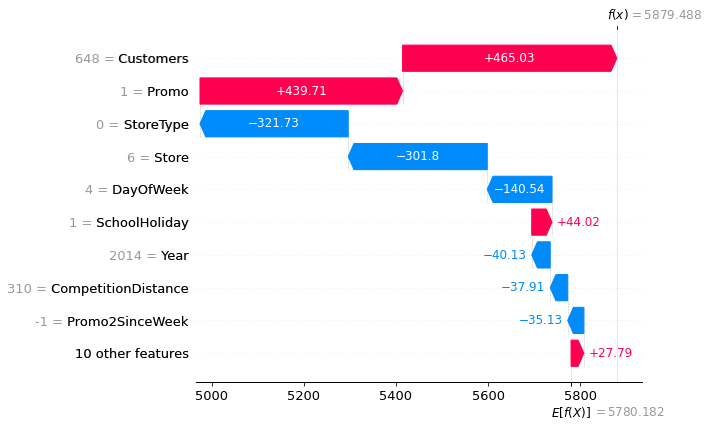

In [24]:
idx=0
shap.plots.waterfall(exp[idx])